Monte Carlo CVA ≈ 512.99 USD


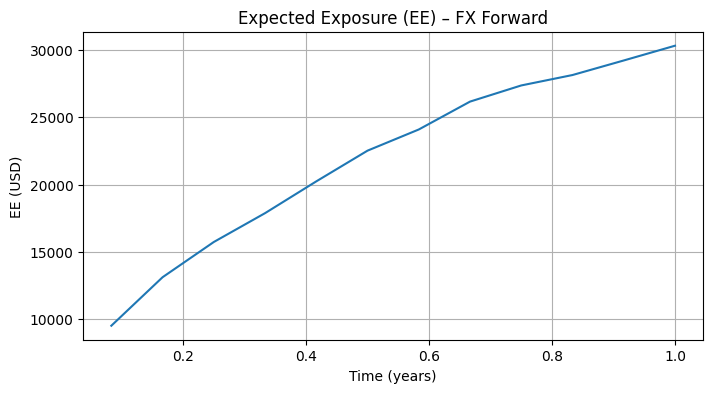

    time        EE  EE_discounted  default_density  cva_contribution
0   0.08   9518.23        9486.56             0.04             19.30
1   0.17  13119.29       13032.12             0.04             26.42
2   0.25  15736.30       15579.72             0.04             31.48
3   0.33  17877.79       17641.01             0.04             35.52
4   0.42  20238.33       19903.82             0.04             39.94
5   0.50  22519.27       22073.36             0.04             44.14
6   0.58  24090.40       23534.80             0.04             46.91
7   0.67  26160.70       25472.30             0.04             50.60
8   0.75  27361.05       26552.41             0.04             52.56
9   0.83  28134.83       27212.46             0.04             53.69
10  0.92  29215.14       28163.32             0.04             55.37
11  1.00  30311.02       29122.51             0.04             57.06


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Step 1 - Input Params
Spot = 1.15 #EUR/USD Spot Rate
Rd = 0.04 #Domestic Interest Rate (USD in this case)
Rf = 0.02 #Foreign Interest Rate (EUR in this case)
Vol = 0.07 #Volatility
T = 1 #Tenor
Notional = 1000000
PD = 0.04 #Probability of default 
RR = 0.4  #Recover rate
LGD = 1 - RR # Loss given default

paths = 1000  #Number of simulations
steps = 12 #Number of time steps
dt = T/steps 
times = np.linspace(dt,T,steps)

lambda_h = -np.log(1 - PD)

np.random.seed(42) #Gave an aribtrary seed number to ensure replication across repeated runs
mu= Rd - Rf 
sqrt_dt = np.sqrt(dt)

Z = np.random.normal(size=(paths,steps))
S = np.zeros((paths,steps+1))
S[:,0] = Spot #Initialize today to Spot for 0th time step

for i in range(steps):
    S[:,i+1] = S[:,i]*np.exp((mu - 0.5*Vol*Vol)*dt + Vol*sqrt_dt*Z[:,i])

K = Spot*np.exp((Rd - Rf)*T)

V = np.zeros((paths,steps))
for i,t in enumerate(times):
    tau = T-t 
    df_for = np.exp(-Rf * tau)
    df_dom = np.exp(-Rd * tau)
    V[:,i] = S[:,i+1]*df_for - K * df_dom 

exposure = np.maximum(V, 0) * Notional 

EE = exposure.mean(axis=0)
discount = np.exp(-Rd * times)
EE_disc = EE * discount 

f_t = lambda_h * np.exp(-lambda_h * times)

# CVA = ∑ LGD * EE(t) * f(t) * dt
cva_contrib = LGD * EE_disc * f_t * dt
CVA = cva_contrib.sum()

print(f"Monte Carlo CVA ≈ {CVA:,.2f} USD")

# Plot EE profile
plt.figure(figsize=(8,4))
plt.plot(times, EE)
plt.title("Expected Exposure (EE) – FX Forward")
plt.xlabel("Time (years)")
plt.ylabel("EE (USD)")
plt.grid(True)
plt.show()

# Optional: dataframe of CVA time buckets
df = pd.DataFrame({
    "time": times,
    "EE": EE,
    "EE_discounted": EE_disc,
    "default_density": f_t,
    "cva_contribution": cva_contrib
})
print(df.round(2))